In [1]:
import torch
from torch import tensor
import matplotlib as mpl, matplotlib.pyplot as plt
import gzip, pickle
from pathlib import Path
from torch import nn
import torch.nn.functional as F
from fastcore.test import test_close
from functools import reduce
import random
from itertools import islice
import fastcore.all as fc

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

In [3]:
data_path = Path('data/mnist.pkl.gz')
with gzip.open(data_path, "rb") as f :
    ((x_train,y_train),(x_valid, y_valid),_) = pickle.load(f,encoding="latin-1")
x_train,y_train,x_valid, y_valid = map(tensor,[x_train,y_train,x_valid, y_valid])

In [4]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [5]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh,n_out)]

    def __call__(self,x):
        for l in self.layers: x = l(x)
        return x

In [6]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [7]:
def log_softmax(x): return (x.exp()/(x.exp().sum(dim=1,keepdim=True))).log()

In [8]:
log_softmax(pred)

tensor([[-2.36, -2.28, -2.09,  ..., -2.43, -2.47, -2.11],
        [-2.37, -2.25, -2.09,  ..., -2.46, -2.43, -2.11],
        [-2.34, -2.31, -2.14,  ..., -2.44, -2.48, -2.14],
        ...,
        [-2.26, -2.25, -2.13,  ..., -2.36, -2.53, -2.17],
        [-2.39, -2.30, -2.18,  ..., -2.38, -2.42, -2.11],
        [-2.40, -2.25, -2.14,  ..., -2.38, -2.45, -2.23]], grad_fn=<LogBackward0>)

In [9]:
def log_softmax(x): return x - x.exp().sum(dim=1,keepdim=True).log()

In [10]:
log_softmax(pred)

tensor([[-2.36, -2.28, -2.09,  ..., -2.43, -2.47, -2.11],
        [-2.37, -2.25, -2.09,  ..., -2.46, -2.43, -2.11],
        [-2.34, -2.31, -2.14,  ..., -2.44, -2.48, -2.14],
        ...,
        [-2.26, -2.25, -2.13,  ..., -2.36, -2.53, -2.17],
        [-2.39, -2.30, -2.18,  ..., -2.38, -2.42, -2.11],
        [-2.40, -2.25, -2.14,  ..., -2.38, -2.45, -2.23]], grad_fn=<SubBackward0>)

In [11]:
def logsumexp(x):
    a = x.max(dim=1)[0]
    return a + (x-a[:,None]).exp().sum(dim=1).log() 

In [12]:
pred-logsumexp(pred)[:,None]

tensor([[-2.36, -2.28, -2.09,  ..., -2.43, -2.47, -2.11],
        [-2.37, -2.25, -2.09,  ..., -2.46, -2.43, -2.11],
        [-2.34, -2.31, -2.14,  ..., -2.44, -2.48, -2.14],
        ...,
        [-2.26, -2.25, -2.13,  ..., -2.36, -2.53, -2.17],
        [-2.39, -2.30, -2.18,  ..., -2.38, -2.42, -2.11],
        [-2.40, -2.25, -2.14,  ..., -2.38, -2.45, -2.23]], grad_fn=<SubBackward0>)

In [13]:
def log_softmax(x):
    return x - logsumexp(x)[:,None]

In [14]:
sm_pred = log_softmax(pred)

In [15]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

In [16]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [17]:
F.log_softmax(pred,-1)

tensor([[-2.36, -2.28, -2.09,  ..., -2.43, -2.47, -2.11],
        [-2.37, -2.25, -2.09,  ..., -2.46, -2.43, -2.11],
        [-2.34, -2.31, -2.14,  ..., -2.44, -2.48, -2.14],
        ...,
        [-2.26, -2.25, -2.13,  ..., -2.36, -2.53, -2.17],
        [-2.39, -2.30, -2.18,  ..., -2.38, -2.42, -2.11],
        [-2.40, -2.25, -2.14,  ..., -2.38, -2.45, -2.23]], grad_fn=<LogSoftmaxBackward0>)

In [18]:
pred.logsumexp(-1)

tensor([2.31, 2.31, 2.29,  ..., 2.34, 2.32, 2.32], grad_fn=<LogsumexpBackward0>)

In [19]:
F.nll_loss(pred-pred.logsumexp(-1)[:,None],y_train)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [20]:
F.nll_loss(F.log_softmax(pred,-1),y_train)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [21]:
F.cross_entropy(pred,y_train)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [22]:
loss_func = F.cross_entropy

In [23]:
bs = 50
lr = 0.5
epochs = 3

In [24]:
model(x_train[0:bs]).argmax(dim=1).shape, y_train[0:bs].shape

(torch.Size([50]), torch.Size([50]))

In [25]:
def accuracy(out, targ): return (out.argmax(dim=1)==targ).float().mean()

In [26]:
accuracy(model(x_train[0:bs]),y_train[0:bs])

tensor(0.16)

In [27]:
def report(out, targ): print(f'loss: {loss_func(out, targ):.2f}, accuracy: {accuracy(out, targ):.2f}')

In [28]:
report(pred, y_train)

loss: 2.30, accuracy: 0.13


In [29]:
model = Model(m, nh, 10)
bs = 50
lr = 0.5
epochs = 3
xb, yb = x_train[:bs], y_train[:bs]
report(xb,yb)

loss: 6.84, accuracy: 0.00


In [30]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i,min(n,i+bs))
        xb, yb = x_train[s], y_train[s]
        pred = model(xb)
        loss = loss_func(pred,yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l,"weight"):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.data.zero_()
                    l.bias.grad.data.zero_()
    report(pred, yb) 


loss: 0.12, accuracy: 0.96
loss: 0.09, accuracy: 0.96
loss: 0.10, accuracy: 0.94


In [31]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [32]:
for i,l in enumerate (model.children()): print(i,l)

0 Linear(in_features=784, out_features=50, bias=True)
1 ReLU()
2 Linear(in_features=50, out_features=10, bias=True)


In [33]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [34]:
model.parameters()

<generator object Module.parameters at 0x7f6336e5f530>

In [35]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i,min(n,i+bs))
            xb, yb = x_train[s], y_train[s]
            pred = model(xb)
            loss = loss_func(pred,yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): 
                    p -= p.grad * lr
                model.zero_grad() 
        report(pred, yb) 

In [36]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10)]

In [37]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [38]:
model = Model(layers)
model

Model(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [39]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate (self.layers): self.add_module(f'layer_{i}',l)
    
    def forward(self, x):
        return reduce(lambda val, layer: layer(val), self.layers, x)

In [40]:
model = Model(layers)
fit()

loss: 0.13, accuracy: 0.96
loss: 0.10, accuracy: 0.96
loss: 0.06, accuracy: 0.98


In [41]:
from typing import Any


class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules_register = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)

    def __setattr__(self, k, v):
        if not k.startswith('_'): self._modules_register[k]=v
        super().__setattr__(k,v)
    
    def __repr__(self): return f'{self._modules_register}'

    def parameters(self): 
        for l in self._modules_register.values(): yield from l.parameters()

In [42]:
model = MyModule(m,nh,10)

In [43]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [44]:
class Optimizer():
    def __init__(self, parameters, lr=lr): 
        self.parameters = list(parameters) ; self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.parameters:
                p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.parameters: p.grad.data.zero_()

In [45]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10))
    return (model, Optimizer(model.parameters())) 

In [46]:
model, opt = get_model()

In [47]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i,min(n,i+bs))
        xb, yb = x_train[s], y_train[s]
        pred = model(xb)
        loss = loss_func(pred,yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(pred, yb) 

loss: 0.15, accuracy: 0.94
loss: 0.08, accuracy: 0.96
loss: 0.06, accuracy: 0.96


In [48]:
class Dataset():
    def __init__(self, inp, targ): self.inp, self.targ = inp, targ

    def __len__(self): return len(self.inp)

    def __getitem__(self, idx): return self.inp[idx], self.targ[idx] 
        

In [49]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [50]:
xb, yb = train_ds[0:bs]

In [51]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [52]:
model, opt = get_model()

In [53]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb, yb = train_ds[i:min(n,i+bs)]
        pred = model(xb)
        loss = loss_func(pred,yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(pred, yb) 

loss: 0.16, accuracy: 0.96
loss: 0.11, accuracy: 0.96
loss: 0.05, accuracy: 0.98


In [54]:
class Dataloader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs

    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:min(n,i+bs)]

In [55]:
dl_train, dl_valid = Dataloader(train_ds, bs), Dataloader(valid_ds, bs)

In [56]:
model, opt = get_model()
for epoch in range(epochs):
    for xb, yb in dl_train:
        pred = model(xb)
        loss = loss_func(pred,yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(pred, yb) 

loss: 0.14, accuracy: 0.92
loss: 0.11, accuracy: 0.96
loss: 0.07, accuracy: 0.98


In [57]:
it = iter(dl_train)
xb, yb = next(it)
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [58]:
xb, yb = next(iter(dl_train))
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3])

tensor(1)

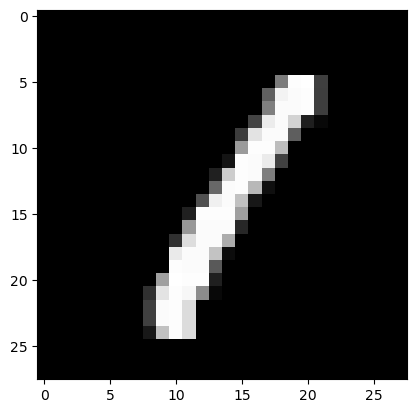

In [59]:
plt.imshow(xb[3].view(28,28))
yb[3]

In [60]:
class Sampler():
    def __init__(self, ds, shuffle = False): self.ds, self.shuffle = ds, shuffle

    def __iter__(self):
        res = list(range(len(self.ds)))
        if self.shuffle: random.shuffle(res)
        return iter(res)


In [61]:
ss = Sampler(train_ds)
it = iter(ss)

In [62]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [63]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [64]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [65]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [66]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [67]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

In [68]:
a = [('a',"b"),('c',"d")]
xs, ys = zip(*a)
xs, ys


(('a', 'c'), ('b', 'd'))

In [69]:
def test(b):
    print(*b)

b = [0,1]
test(train_ds[i] for i in b)

(tensor([0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.07,
        0.07, 0.07,

In [70]:
from fastcore.all import store_attr
class Dataloader_MT():
    def __init__(self, ds, bs, shuffle=False): fc.store_attr()

    def __iter__(self):
        self.res = list(range(len(self.ds)))
        if self.shuffle: random.shuffle(self.res)
        for i in fc.chunked(iter(self.res), self.bs):
            yield self.ds[i]

In [71]:
train_dl_mt = Dataloader_MT(train_ds, bs,shuffle=True)

In [72]:
xb, yb = next(iter(train_dl_mt))

(<matplotlib.image.AxesImage at 0x7f6336dcef50>, tensor(5))

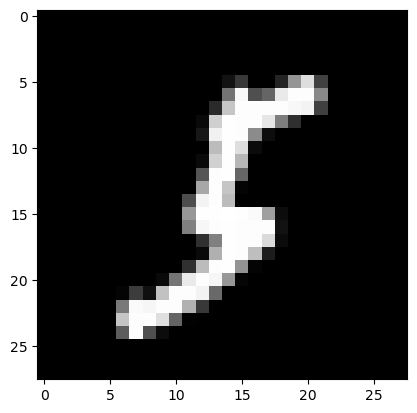

In [73]:
plt.imshow(xb[0].view(28,28)),yb[0]

In [74]:
from torch.utils.data import DataLoader

In [75]:
def get_dls (train_ds, valid_ds, bs, **kwargs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs*2, shuffle=False, **kwargs)
    )

In [76]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)

In [82]:
xb,yb = next(iter(train_dl))
xb.shape, bs

(torch.Size([50, 784]), 50)

In [178]:
model, opt = get_model()

In [179]:
def fit(epochs, model, loss_func ,opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb),yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            count, total_accuracy, total_loss = 0, 0. ,0.
            for xb, yb in valid_dl:
                pred = model(xb)
                loss = loss_func(pred,yb)
                n = len(xb)
                count += n
                total_accuracy += accuracy(pred,yb).item()*n
                total_loss     += loss_func(pred,yb).item()*n
            
        print(epochs,total_loss/count, total_accuracy/count)
        
    return total_loss/count, total_accuracy/count

In [180]:
loss, accuracy = fit(epochs, model, loss_func ,opt, train_dl, valid_dl) 

3 0.1513418527878821 0.9561000049114228
3 0.12390999983996152 0.9651000082492829
3 0.1282746159657836 0.9634000033140182


In [176]:
def accuracy(out, targ): return (out.argmax(dim=1)==targ).float().mean()

In [162]:
class BatchSampler_MT():
    def __init__(self, sampler, bs): fc.store_attr()

    def __iter__():
        yield from fc.chunked(self.sampler, bs)

In [ ]:
class Dataloader2():
    def __init__(self,ds,batchsamp): fc.store_attr()

    def __iter__():
        yield from (collate(ds[i] for i in b) for b in self.batchsamp)